# TODO / Commentaire
 - Est ce qu'on met en log les births ?
 - 
 
 use of contraceptive method
 abortion
 impact of emmigration
 children as workpower

# Wesh les reufs bien ou quoi

Importing data:
 - `valeurs_mensuelles.csv`: containing the number of birth in France for each month from 01-01-2004 to 01-10-2020.<br>
 Columns:
     - Période: month
     - Démographie - Nombre de naissances vivantes - France métropolitaine: number of birth for the corresponding month
     - Codes: Codes for explaining what type of value we have in our case we have "P" for 2020 data standing for "provisional" and "A" everywhere else standing for normale value. (see `caract.csv` for further details)
 - `GTD.csv`: containing the query number of google trend data for different categories.<br>
   This dataframe is created in the notebook `GTD_preprocessing.ipynb`.<br>
 Columns:
     - date: date of the query number
     - category id : columns containing all the query number in France for this category.
     
 - `categories.csv`: containing all the ids and names of the google trend categories<br>
   This dataframe is created in the notebook `GTD_preprocessing.ipynb`. The categories can be seen as a list with sub-categories here: https://github.com/pat310/google-trends-api/wiki/Google-Trends-Categories<br>
 Columns:
     - id: id of the diffrent category
     - name: Name of this category

In [1]:
#***Attention***  les donnees n'ont pas les memes tailles
#valeurs mensuelle = 202x1        01-01-2004  --> 01-10-2020 
#GTD               = 204×916      01-01-2004  --> 01-12-2020       916 categories       (donnée incomplete pour decembre)    (certaines categories ne donne pas de resultat exemple : category 42 "jazz" https://trends.google.com/trends/explore?cat=42&date=all&geo=FR )
# categories       = 1133x3                                       1133 categories       (il y a bien 1133 category differentes sur google trend mais dans GTD on a enlevé les category sans resultat  il en reste 916)

In [2]:
# Clear all variables
%reset -f

# Importing librairies: numpy, matplotlib, pandas, statmodel
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.regression.rolling import RollingOLS

In [3]:
# Importing birth data with selecting correct columns and changing columns names
data_folder = './Data/'
birth_df = pd.read_csv(data_folder +'valeurs_mensuelles.csv', sep= ';', index_col= 0, skiprows=2, usecols=[0,1],header=0, names=['Période','birth'])

# Changing indexes to panda date
birth_df.index = pd.to_datetime(birth_df.index)

# Putting sales data in log scale as we want
birth_df['birth'] = birth_df['birth'].apply(np.log)

# Getting an overview
birth_df = birth_df.sort_index()
birth_df

,birth
Période,
2004-01-01,11.067248
2004-02-01,10.989048
2004-03-01,11.018383
2004-04-01,11.020529
2004-05-01,11.026028
...,...
2020-06-01,10.978490
2020-07-01,11.044521
2020-08-01,11.008744


In [4]:
def standardize(data):
    mean_x = np.mean(data)
    std_x = np.std(data)
    x = data
    x = x - mean_x
    for i in range (len(std_x)):
        if std_x[i] == 0:
            std_x[i]=1
    x = x / std_x
    return x

In [5]:
# Importing google trend data
from numpy import linalg as LA
GTD_df = pd.read_csv(data_folder +'GTD.csv',index_col= 0)

# Getting an overview
GTD_df = GTD_df.loc['2004-01-01':'2020-10-01']
col = pd.to_numeric(GTD_df.columns)
GTD_df = standardize(GTD_df)
GTD_df.head(10)

,0,3,5,7,8,11,12,13,14,16,...,1381,1385,1386,1387,1388,1389,1390,1391,1392,1397
date,,,,,,,,,,,,,,,,,,,,,
2004-01-01,5.249401,-0.286742,1.946000,-1.837663,-0.099506,-2.317342,0.415269,-0.039441,0.549825,-1.000649,...,-1.039552,2.105135,0.870921,0.312119,-0.637383,-0.615030,-0.842779,1.832274,1.631805,0.049782
2004-02-01,2.377302,-0.286742,1.734501,-1.736351,-0.099506,-2.694034,0.415269,-0.272394,0.083493,-1.295731,...,-1.039552,3.883694,1.687456,2.399076,1.952096,1.302193,1.318254,1.650784,2.426081,-0.210737
2004-03-01,1.573114,-0.167806,1.776801,-1.027165,-0.146800,-2.317342,0.643629,-0.086031,0.472103,-0.803928,...,-1.119003,1.242803,1.613226,0.531799,1.590774,-0.167678,-2.363506,1.711280,1.548197,-0.210737
2004-04-01,0.194507,-0.108338,1.776801,-1.331102,-0.004917,-1.815085,0.719749,-0.272394,0.394381,-1.000649,...,-1.079277,3.236945,4.433983,1.849877,2.192978,2.260804,-1.002856,1.469293,2.676905,-0.210737
2004-05-01,2.377302,-0.108338,1.819101,-2.242912,-0.052211,-1.815085,0.491389,-0.086031,0.394381,-0.803928,...,-1.079277,-0.751338,1.613226,0.751479,0.326144,1.238285,2.518828,0.985319,1.840825,0.310302
2004-06-01,-0.954333,-0.048870,1.776801,-1.635039,0.089672,-1.689521,0.948109,0.053741,0.472103,-0.803928,...,-1.079277,1.081116,1.613226,3.167955,0.807908,2.580341,-0.442588,1.892771,2.133453,0.622925
2004-07-01,1.917766,-0.346210,1.565302,-1.533727,-0.052211,-1.940649,0.186909,0.007150,-0.227394,-1.197371,...,-1.039552,1.188908,-2.172527,0.971158,1.169231,1.430007,-1.803239,2.013764,2.593297,0.206094
2004-08-01,0.654042,-0.524614,1.396103,-2.141600,-0.004917,-1.689521,-0.498172,-0.225803,-0.382838,-1.492453,...,-1.039552,0.649950,0.277078,0.092439,-1.179367,1.302193,-2.283468,0.682835,2.342473,-0.158633
2004-09-01,2.032650,-0.227274,1.946000,-1.027165,-0.052211,-1.312829,1.100349,0.426465,0.394381,-1.394092,...,-1.039552,3.398632,2.281300,0.531799,2.253198,0.151859,1.638407,1.711280,1.339177,-0.106529


In [6]:
# Importing google trend categories
categories_df = pd.read_csv(data_folder +'categories.csv',index_col= 0)

# Keeping only the elements of interest and getting an overview
categories_df = categories_df[categories_df['id'].isin(col)]
categories_df

,id,name
1426,0,Toutes catégories
240,3,Arts et divertissements
715,5,Informatique et électronique
396,7,Finance
785,8,Jeux
...,...,...
1415,1389,Agritourisme
1418,1390,Visites touristiques
1417,1391,Oenotourisme
1412,1392,Offices du tourisme et syndicats d'initiative


## Analyse des categories et selection

start_date, end_date: start and end date of the total period

 
best_selection = 
 - 1: par correlation
 - 2: par improvement solo
 - 3: par improvement solo on the last shift months ex 12 best improvements on the lasts 12 months

 
Remove_seasonnality = 
 - 0: no
 - 1 : yes
 
nb_category_prediction: number of category used for prediction (1-20)

In [7]:
start_date = '2004-01-01' #'2015-01-01'   #'2004-01-01'
end_date = '2005-01-01'

normalisation_GTD = 1
 
best_selection = 3
shift = 1
 
Remove_seasonnality = 0
 
nb_category_prediction = 3

k = 17

# do not touch 
months_shift = k+shift

In [146]:
birth_df

,birth,birth_6,birth_12
Période,,,
2004-01-01,11.067248,0.000000,0.000000
2004-02-01,10.989048,0.000000,0.000000
2004-03-01,11.018383,0.000000,0.000000
2004-04-01,11.020529,0.000000,0.000000
2004-05-01,11.026028,0.000000,0.000000
...,...,...,...
2020-06-01,10.978490,10.998744,10.998226
2020-07-01,11.044521,10.986986,11.075645
2020-08-01,11.008744,10.887437,11.050858


### Seasonnality


<AxesSubplot:xlabel='Période'>

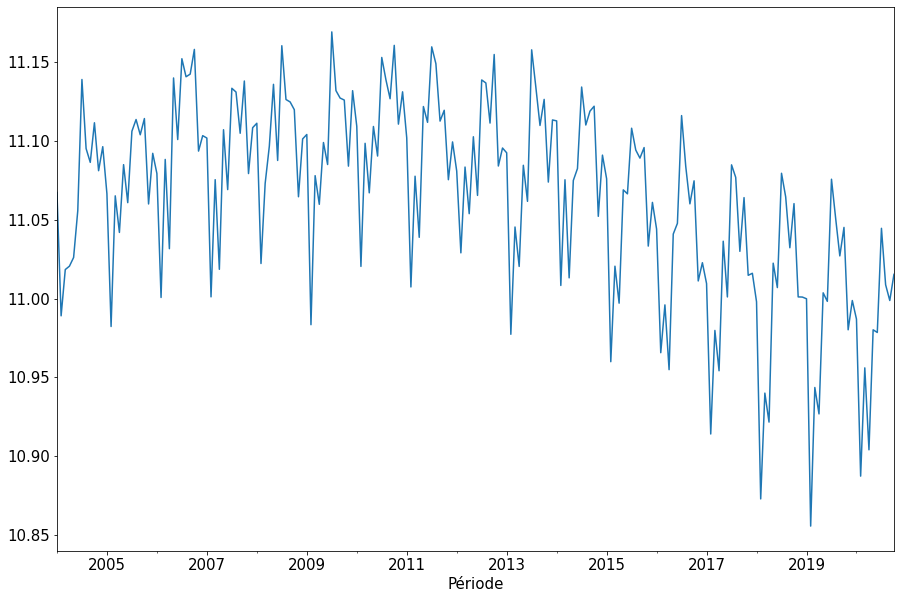

In [150]:
from statsmodels.tsa.seasonal import STL
Remove_seasonnality=1
if Remove_seasonnality == 1:
    birth = STL(birth_df.birth).fit()
    birth_df['births'] = birth_df['birth'] - birth.seasonal
    
birth_df['birth'].plot()

### Shifting columns

In [9]:
nan = np.empty(6)
nan[:] = 0
birth_df['birth_6'] =  [*nan , *birth_df.birth[:-6].values] # Moving down 6 rows and putting 0 in the empty space
nan = np.empty(12)
nan[:] = 0
birth_df['birth_12'] =  [*nan , *birth_df.birth[:-12].values] # Moving down 12 rows and putting 0 in the empty space 

### Start date /end date

### Normalisation GTD

### Correlation

In [131]:
from dateutil.relativedelta import relativedelta
from datetime import datetime

In [132]:
#Feature selection on the ENTIRE DATASET
#best_selection=1
#if best_selection==1:
def best_feature_correlation(date, k, GTD_df, birth_df, categories_df):
    # CORRELATION
    pearson = []
    kendall = []
    spearman = []
    
    end_date = datetime.strptime(date, '%Y-%m-%d')  
    start_date = end_date - relativedelta(months=+k)

    end_date = datetime.strftime(end_date, '%Y-%m-%d')
    start_date = datetime.strftime(start_date, '%Y-%m-%d')

    temp_df=pd.DataFrame(GTD_df.loc[start_date:end_date], dtype='float') #Taking the time index that are also in the birth_df
    birth_temp = pd.DataFrame(birth_df.loc[start_date:end_date], dtype='float')
    for i,j in enumerate(categories_df['id']):

        if str(j) in temp_df.columns:
            #Pearson correlation calculation
            pearsonTemp = np.abs(birth_temp.iloc[:,0].corr(temp_df[str(j)],method='pearson'))
            pearson.append(pearsonTemp)
            #Kendall correlation calculation
            kendallTemp = np.abs(birth_temp.iloc[:,0].corr(temp_df[str(j)],method='kendall'))       
            kendall.append(kendallTemp)
            #Spearman correlation calculation
            spearmanTemp = np.abs(birth_temp.iloc[:,0].corr(temp_df[str(j)],method='spearman'))
            spearman.append(spearmanTemp)

        else:
            pearson.append(np.nan)
            kendall.append(np.nan)
            spearman.append(np.nan)

    #Normalizing our correlation indicators in order to combine them
    pearsonNorm = 100 / np.nanmax(pearson)
    categories_df['Pearson'] = np.multiply(pearsonNorm, pearson)
    kendallNorm = 100 / np.nanmax(kendall)    
    categories_df['Kendall'] = np.multiply(kendallNorm, kendall)
    spearmanNorm = 100 / np.nanmax(spearman)
    categories_df['Spearman'] = np.multiply(spearmanNorm, spearman)

    #Crossing between our correlations to see which feature is the best
    cal = pd.DataFrame([categories_df["Spearman"], categories_df["Pearson"], categories_df["Kendall"]]).transpose()
    cal = cal.mean(axis=1)
    categories_df['Mean'] = cal

    #Displaying the 10 best
    categories_best = categories_df.sort_values('Mean', ascending=False).iloc[0:20,:].reset_index(drop=True)
    
    # Create the dataframe with GTD
    predict_gtd = pd.DataFrame(index = birth_df.index, dtype='int')
    for i in range (nb_category_prediction):
        predict_gtd[str("id{}".format(categories_best.index[i]))] = np.ones((len(birth_df),1)) * categories_best.id[i]
        
    return  categories_best

In [133]:
def daterange(start_date, end_date):
    for n in range(k, rep):#GTD_df.shape[0]):
        yield start_date + relativedelta(months=n)

k=16
start_date = '2004-01-01' 
end_date = '2010-01-01'
rep = len(pd.date_range(start_date,end_date, freq='M'))

start_date = datetime.strptime(start_date, '%Y-%m-%d')  
end_date = datetime.strptime(end_date, '%Y-%m-%d')

best = pd.DataFrame()
for single_date in daterange(start_date, end_date):
    date = single_date.strftime("%Y-%m-%d")
    tab = best_feature_correlation(date, k, GTD_df, birth_df, categories_df)
    best[date]=tab.id[0:10]
    print(date)


2005-05-01
2005-06-01
2005-07-01
2005-08-01
2005-09-01
2005-10-01
2005-11-01
2005-12-01
2006-01-01
2006-02-01
2006-03-01
2006-04-01
2006-05-01
2006-06-01
2006-07-01
2006-08-01
2006-09-01
2006-10-01
2006-11-01
2006-12-01
2007-01-01
2007-02-01
2007-03-01
2007-04-01
2007-05-01
2007-06-01
2007-07-01
2007-08-01
2007-09-01
2007-10-01
2007-11-01
2007-12-01
2008-01-01
2008-02-01
2008-03-01
2008-04-01
2008-05-01
2008-06-01
2008-07-01
2008-08-01
2008-09-01
2008-10-01
2008-11-01
2008-12-01
2009-01-01
2009-02-01
2009-03-01
2009-04-01
2009-05-01
2009-06-01
2009-07-01
2009-08-01
2009-09-01
2009-10-01
2009-11-01
2009-12-01


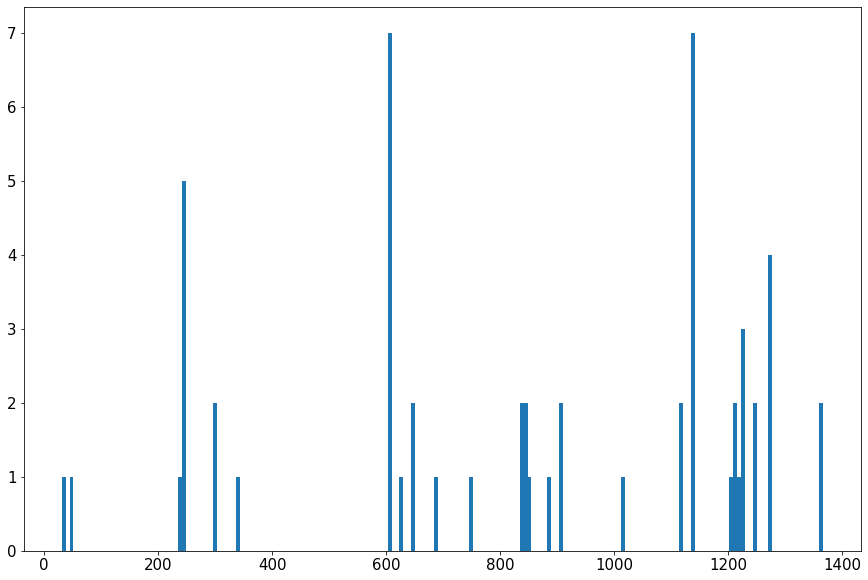

In [134]:
plt.hist(best.iloc[0,:], bins = 196)
plt.show()

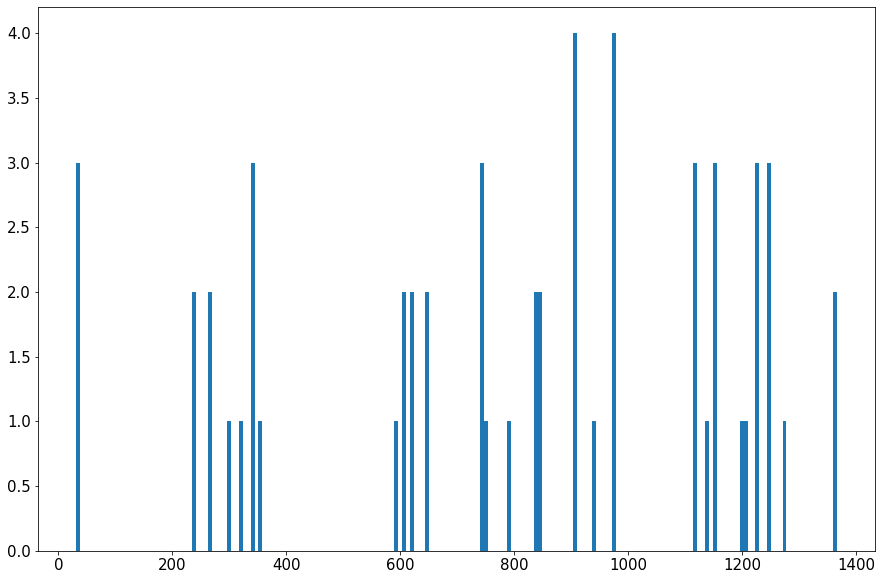

In [135]:
plt.hist(best.iloc[1,:], bins = 196)
plt.show()

In [136]:
#if 1==1:
def prediction(date,k,birth_df,GTD,ids):
    '''
    date= '2007-01-01' 
    ids=best[date][0:1]
    '''
    df = birth_df.copy()
    temp_GTD = GTD_df.copy()
    
    end = datetime.strptime(date, '%Y-%m-%d')  
    start = end - relativedelta(months=+k)
    end = datetime.strftime(end, '%Y-%m-%d')
    start = datetime.strftime(start, '%Y-%m-%d')
    
    df = df.loc[start:end]
    temp_GTD = temp_GTD.loc[start:end]
    
    #Features selection
    formula = str('birth ~ birth_6 + birth_12')
    columns_name = ['b0','b1','b2']
    for j,i in enumerate(ids):
        df["y%d"%j] = temp_GTD.loc[:,str(int(i))]
        formula = formula + ' + ' + str("y%d"%j)
        columns_name.append(str("b%d"%(j+ 3)))
        #GTD_df.loc[:,str(categories_best.id[i])]

    index_date = df.index #saving the index for later plotting
    df = df.reset_index(drop=True) #Resetting the index to [0-n] format


    res_base = RollingOLS.from_formula('birth ~ birth_6 + birth_12', data=df, window=k).fit() #We use our rolling windows function
    params = pd.DataFrame(res_base.params.shift(periods=1, axis=0)) #we shift the output parameters one row down in order to apply to the next mont (predict)
    params.columns = ['a0','a1','a2'] #Changing the parameters' columns names
    df = pd.concat([df, params], axis=1) #adding it to our dataframe
    df['predict_base'] = df.a0 + df.a1*df.birth_6 + df.a2*df.birth_12 #predicting the values for the next month

    res_trend = RollingOLS.from_formula(formula, data=df, window=k).fit()#We use our rolling windows function
    params = pd.DataFrame(res_trend.params.shift(periods=1, axis=0)) #we shift the output parameters one row down in order to apply to the next mont (predict)
    params.columns = columns_name#Changing the parameters' columns names
    df = pd.concat([df, params], axis=1) #adding it to our dataframe
    df['predict_trend'] = df.b0 + df.b1*df.birth_6 + df.b2*df.birth_12 
    for j,i in enumerate(ids):
        df['predict_trend'] = df['predict_trend'] + params.iloc[:,3+j]*  df.iloc[:,3+j]  #predicting the values for the next month


    #add date index again
    df.index = index_date

    #MAE + Improvement overall calculation between the base fit and base+trend fit
    mae_base = np.mean(abs(df.birth-df.predict_base))*100
    mae_trends = np.mean(abs(df.birth-df.predict_trend))*100
    improvement_overall = (mae_base-mae_trends)*100 /mae_base
    return df,improvement_overall


In [137]:
k=16
imp=[]
base =[]
trend=[]
for single_date in daterange(start_date, end_date):
    date = single_date.strftime("%Y-%m-%d")
    print(date)
    aze, impt = prediction(date,k,birth_df,GTD_df,best[date][0:1])
    base.append(aze['predict_base'][-1])
    trend.append(aze['predict_trend'][-1])
    imp.append(impt)

2005-05-01
2005-06-01
2005-07-01
2005-08-01
2005-09-01
2005-10-01
2005-11-01
2005-12-01
2006-01-01
2006-02-01
2006-03-01
2006-04-01
2006-05-01
2006-06-01
2006-07-01
2006-08-01
2006-09-01
2006-10-01
2006-11-01
2006-12-01
2007-01-01
2007-02-01
2007-03-01
2007-04-01
2007-05-01
2007-06-01
2007-07-01
2007-08-01
2007-09-01
2007-10-01
2007-11-01
2007-12-01
2008-01-01
2008-02-01
2008-03-01
2008-04-01
2008-05-01
2008-06-01
2008-07-01
2008-08-01
2008-09-01
2008-10-01
2008-11-01
2008-12-01
2009-01-01
2009-02-01
2009-03-01
2009-04-01
2009-05-01
2009-06-01
2009-07-01
2009-08-01
2009-09-01
2009-10-01
2009-11-01
2009-12-01


In [138]:
np.mean(imp)

-44.93695391052894

In [140]:
df = birth_df.loc['2005-05-01':'2009-12-01'].copy()
df['predict_base'] = base
df['predict_trend'] = trend

In [141]:
df

,birth,birth_6,birth_12,predict_base,predict_trend
Période,,,,,
2005-05-01,11.084877,11.081050,11.026028,11.038816,11.038025
2005-06-01,11.060793,11.096273,11.055688,11.047981,11.047426
2005-07-01,11.106069,11.066435,11.138857,11.049548,11.056986
2005-08-01,11.113492,10.982288,11.095074,11.057431,11.096371
2005-09-01,11.103814,11.065106,11.086334,11.065040,11.097051
2005-10-01,11.114103,11.041913,11.111432,11.069227,11.079821
2005-11-01,11.059960,11.084877,11.081050,11.070759,11.067951
2005-12-01,11.092062,11.060793,11.096273,11.081154,11.097276
2006-01-01,11.079277,11.106069,11.066435,11.057442,11.064894


## improvement function

In [189]:
#size of the rolling window = 17 = 4 mois ds le précédent paper, on prend 6 dans celui là comme en plus on a une saisonnalité de 6 mois
#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5269518/
def best_feature_improvement(k,start = start_date, end = end_date):
    '''
    Input: 
        -start: start date in format '2004-01-01'
        -end: end date in format '2020-10-01'
        k: rolling windows size, recommended size : 6
    '''


    improvement = []

    #Checking for each feature
    for i in GTD_df.columns:

        #Setting the dfs
        df = birth_df.copy()
          

        #Setting the feature of interest
        df[str("y0")] = GTD_df[str(i)]
        df = df.loc[start:end]
        df = df.reset_index(drop=True) #Resetting the index to [0-n] format

        #Basic reg
        res_base = RollingOLS.from_formula('birth ~ birth_6 + birth_12', data=df, window=k).fit() #We use our rolling windows function
        params = pd.DataFrame(res_base.params.shift(periods=1, axis=0)) #we shift the output parameters one row down in order to apply to the next mont (predict)
        params.columns = ['a0','a1','a2'] #Changing the parameters' columns names
        df = pd.concat([df, params], axis=1) #adding it to our dataframe
        df['predict_base'] = df.a0 + df.a1*df.birth_6 + df.a2*df.birth_12 #predicting the values for the next month

        #Trend reg with feature of interest
        res_trend = RollingOLS.from_formula('birth ~ birth_6 + birth_12 + y0', data=df, window=k).fit()#We use our rolling windows function
        params = pd.DataFrame(res_trend.params.shift(periods=1, axis=0)) #we shift the output parameters one row down in order to apply to the next mont (predict)
        params.columns = ['b0','b1','b2','b3']#Changing the parameters' columns names
        df = pd.concat([df, params], axis=1) #adding it to our dataframe
        df['predict_trend'] = df.b0 + df.b1*df.birth_6 + df.b2*df.birth_12 + df.b3 * df.y0   #predicting the values for the next month

        #Calculating MAE and Improvement
        mae_base = np.mean(abs(df.birth-df.predict_base))*100
        mae_trends = np.mean(abs(df.birth-df.predict_trend))*100
        improvement_overall = (mae_base-mae_trends)*100 /mae_base
        improvement.append(improvement_overall)


    #Our df well ordered
    categories_best = categories_df.reset_index(drop=True)
    categories_best['Improvement'] = pd.DataFrame(improvement)
    categories_best = categories_best.sort_values('Improvement', ascending=False)
    categories_best = categories_best.reset_index(drop=True)
    
    return categories_best

### improvement solo 

In [190]:
if best_selection==2:
    # IMPROVEMENT
    categories_best = best_feature_improvement(k)
    
    # Create the dataframe with GTD
    predict_gtd = pd.DataFrame(index = birth_df.index)
    for i in range (nb_category_prediction):
        predict_gtd[str("id{}".format(categories_best.index[i]))] = np.ones((len(birth_df),1)) * categories_best.id[i]


### Improvement solo sur periode

In [14]:
if best_selection==3:
    #create correct columns names
    columns_name = []
    for i in range (nb_category_prediction):
        columns_name.append(str("id{}".format(i)))
    
    #make shift
    Date_shifted = birth_df.index.shift(-months_shift, freq ='MS') 
    Date_shifted_1 = birth_df.index.shift(-1, freq ='MS') 
    
    predict_gtd = pd.DataFrame(dtype='float')
    categories_best = pd.DataFrame()
    improvements = pd.DataFrame()
    #for each date
    for i in range(months_shift,len(birth_df)):
        #get correct time range
        start = Date_shifted[i]
        end = Date_shifted_1[i]
        #find best categories
        categories_best_temp = best_feature_improvement(k,start,end)
        #add it to df
        predict_gtd = predict_gtd.append(categories_best_temp.id[0:nb_category_prediction].transpose())
        categories_best = categories_best.append(categories_best_temp.name[0:nb_category_prediction].transpose())
        improvements = improvements.append(categories_best_temp.Improvement[0:nb_category_prediction].transpose())
        print(birth_df.index[i])
        
    
    #create dataframe with correct indices and columns name
    predict_gtd.index = birth_df.index[months_shift:]
    predict_gtd.columns = columns_name
    
    categories_best.index = birth_df.index[months_shift:]
    improvements.index = birth_df.index[months_shift:]
    categories_best = pd.merge(categories_best,improvements,left_index = True,right_index = True)


2019-03-01 00:00:00
2019-04-01 00:00:00
2019-05-01 00:00:00
2019-06-01 00:00:00
2019-07-01 00:00:00
2019-08-01 00:00:00
2019-09-01 00:00:00
2019-10-01 00:00:00
2019-11-01 00:00:00
2019-12-01 00:00:00
2020-01-01 00:00:00
2020-02-01 00:00:00
2020-03-01 00:00:00
2020-04-01 00:00:00
2020-05-01 00:00:00
2020-06-01 00:00:00
2020-07-01 00:00:00
2020-08-01 00:00:00
2020-09-01 00:00:00
2020-10-01 00:00:00


### best categories

In [15]:
categories_best.head(10)

,0_x,1_x,2_x,0_y,1_y,2_y
Période,,,,,,
2019-03-01,Gestion des risques,Produits et services de sécurité,Chat vocal et vidéo,99.038759,97.513638,94.754935
2019-04-01,Jeep,Produits et services de sécurité,Planification financière,89.708133,77.687535,74.521728
2019-05-01,Assurance auto,Technologies assistives,Traitement de l'alcoolisme et de la toxicomanie,94.630794,90.349590,88.847858
2019-06-01,Moteurs de recherche,Études de communication,Isuzu,90.937702,89.016172,86.463823
2019-07-01,Empoisonnements et overdoses,Cours de cuisine,Ophtalmologie,99.753538,99.184788,99.038515
2019-08-01,Portes et fenêtres,Services de marketing,Humour,99.710317,99.632261,99.382217
2019-09-01,Bowling,Mitsubishi,Jeux de cartes à collectionner,98.167270,94.805139,93.826862
2019-10-01,Musique en streaming et en téléchargement,Vitamines et compléments,Marketing et publicité,99.494856,99.480882,99.149115
2019-11-01,Soins et protection des animaux,Services de commerce électronique,Tests et mesures,92.735433,90.760834,88.606730


In [16]:
predict_gtd = predict_gtd.astype(int)
predict_gtd

,id0,id1,id2
Période,,,
2019-03-01,620,705,386
2019-04-01,846,705,903
2019-05-01,467,1352,1350
2019-06-01,485,1302,1378
2019-07-01,946,297,246
2019-08-01,827,83,182
2019-09-01,1016,854,923
2019-10-01,220,237,25
2019-11-01,883,340,746


### Final prediction

In [17]:
def prediction(start,end,k,data,GTD,ids):
    df = data.copy()
    temp_GTD = GTD.copy()
    df = df.loc[start:end]
    temp_GTD = temp_GTD.loc[str(start-pd.DateOffset(months=1)):str(end)]
        
    #Features selection
    formula = str('birth ~ birth_6 + birth_12')
    columns_name = ['b0','b1','b2']
    for j,i in enumerate(ids):
        df["y%d"%j] = temp_GTD.loc[:,str(int(i))]
        formula = formula + ' + ' + str("y%d"%j)
        columns_name.append(str("b%d"%(j+ 3)))
        #GTD_df.loc[:,str(categories_best.id[i])]

    index_date = df.index #saving the index for later plotting
    df = df.reset_index(drop=True) #Resetting the index to [0-n] format


    res_base = RollingOLS.from_formula('birth ~ birth_6 + birth_12', data=df, window=k).fit() #We use our rolling windows function
    params = pd.DataFrame(res_base.params.shift(periods=1, axis=0)) #we shift the output parameters one row down in order to apply to the next mont (predict)
    params.columns = ['a0','a1','a2'] #Changing the parameters' columns names
    df = pd.concat([df, params], axis=1) #adding it to our dataframe
    df['predict_base'] = df.a0 + df.a1*df.birth_6 + df.a2*df.birth_12 #predicting the values for the next month

    res_trend = RollingOLS.from_formula(formula, data=df, window=k).fit()#We use our rolling windows function
    params = pd.DataFrame(res_trend.params.shift(periods=1, axis=0)) #we shift the output parameters one row down in order to apply to the next mont (predict)
    params.columns = columns_name#Changing the parameters' columns names
    df = pd.concat([df, params], axis=1) #adding it to our dataframe
    df['predict_trend'] = df.b0 + df.b1*df.birth_6 + df.b2*df.birth_12 
    for j,i in enumerate(ids):
        df['predict_trend'] = df['predict_trend'] + params.iloc[:,3+j]*  df.iloc[:,3+j]  #predicting the values for the next month


    #add date index again
    df.index = index_date

    #MAE + Improvement overall calculation between the base fit and base+trend fit
    mae_base = np.mean(abs(df.birth-df.predict_base))*100
    mae_trends = np.mean(abs(df.birth-df.predict_trend))*100
    improvement_overall = (mae_base-mae_trends)*100 /mae_base
    return df,improvement_overall


In [18]:
temp_df=pd.DataFrame(GTD_df, dtype='float')

#Birth_df Data
df = birth_df.copy()

'''
ids=[]
for i in range (nb_category_prediction):
    ids.append(categories_best.id[i])
[df,improvement_overall] = prediction(start_date,end_date,k,df,temp_df,ids)
'''
predict_base=[np.nan]*(months_shift+1)
predict_trend=[np.nan]*(months_shift+1)
for i in range(months_shift+1,len(birth_df)):
    j=birth_df.index[i]
    ids = predict_gtd.loc[j,:]
    [pred,improvement_overall] = prediction(j -pd.DateOffset(months=months_shift),j,k,df,temp_df,ids)
    predict_base.append(pred['predict_base'][-1])
    predict_trend.append(pred['predict_trend'][-1])

df['predict_base'] = predict_base
df['predict_trend'] = predict_trend


In [19]:
df

,birth,birth_6,birth_12,predict_base,predict_trend
Période,,,,,
2017-09-01,11.029926,10.979786,11.060039,NaN,NaN
2017-10-01,11.063979,10.954222,11.074622,NaN,NaN
2017-11-01,11.014736,11.036356,11.011159,NaN,NaN
2017-12-01,11.016019,11.001016,11.022719,NaN,NaN
2018-01-01,10.997958,11.084755,11.009506,NaN,NaN
2018-02-01,10.872997,11.076805,10.914143,NaN,NaN
2018-03-01,10.940065,11.029926,10.979786,NaN,NaN
2018-04-01,10.921685,11.063979,10.954222,NaN,NaN
2018-05-01,11.022425,11.014736,11.036356,NaN,NaN


### Plotting

<function matplotlib.pyplot.show(close=None, block=None)>

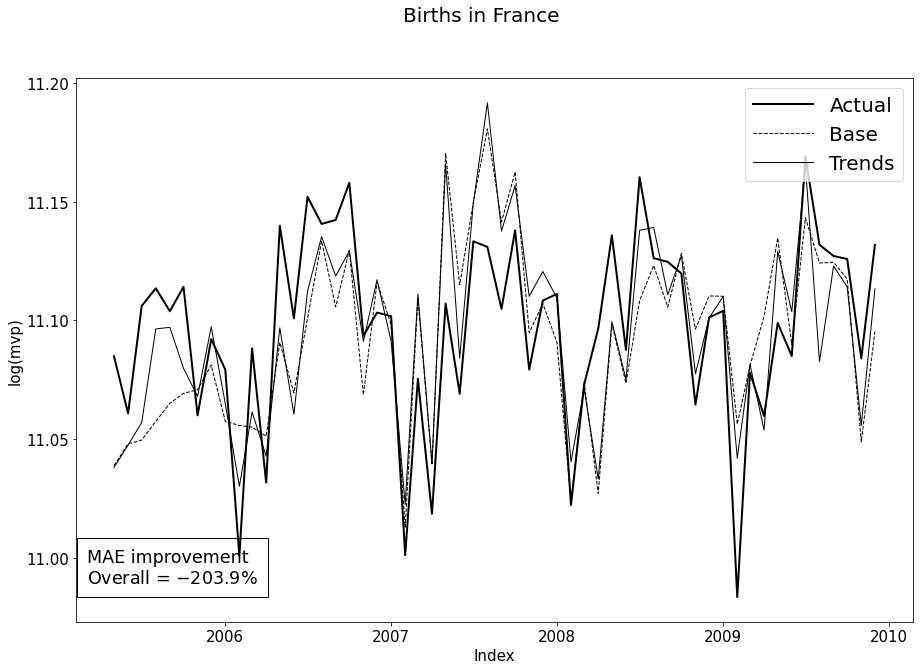

In [142]:
#Defining the overall parameters for the figure
params = {'legend.fontsize': 20,
          'legend.handlelength': 3,
          'figure.figsize': (15,10),
          'axes.labelsize' : 15,
          'xtick.labelsize' : 15,
          'ytick.labelsize' : 15}
plt.rcParams.update(params) #applying them

#plotting each curve with specific parameters
fig, ax = plt.subplots()
ax.plot(df.birth, 'k', linewidth=2, label='Actual') #Thicker line for the real data
ax.plot(df.predict_base, 'k--', linewidth=1,label='Base') #Doted line for the predicted curve with basic data
ax.plot(df.predict_trend, 'k', linewidth=1, label='Trends') #Classic line for the predicted curve with basic + trend data

#Defining figure title
plt.suptitle('Births in France', fontsize=20)

#Defining (x;y) labels
plt.xlabel('Index')
plt.ylabel('log(mvp)')

#Plotting the legend
plt.legend(loc="upper right")

#Creating the box with the MAE improvements
textstr = '\n'.join((
    r'MAE improvement',
    r'Overall = $%.1f$%%' % (improvement_overall, )))
ax.text(0.013, 0.135, textstr, transform=ax.transAxes, fontsize=17.5,
        verticalalignment='top', bbox=dict(facecolor='none', edgecolor='black', pad=10))

#Showing the plot
plt.show